In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import warnings

In [2]:

data = pd.read_csv("APPL_prices.csv", parse_dates=['Date'] ,sep=",")
data.set_index('Date', inplace=True)
data.head()


,Close,High,Low,Open,Volume
Date,,,,,
2023-01-03,123.632530,129.395518,122.742873,128.782649,112117500
2023-01-04,124.907707,127.181276,123.642420,125.431615,89113600
2023-01-05,123.583107,126.301501,123.326101,125.668857,80962700
2023-01-06,128.130203,128.792501,123.454572,124.561702,87754700
2023-01-09,128.654144,131.876686,128.397138,128.970474,70790800


In [3]:
# Cleaning and scaling

from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings("ignore")

scaler = MinMaxScaler(feature_range=(0,1))

data.fillna(method='ffill', inplace=True)

data = data[['Close']]

data['Scaled Close'] = scaler.fit_transform(data[['Close']])

data.head()


,Close,Scaled Close
Date,,
2023-01-03,123.632530,0.000674
2023-01-04,124.907707,0.018060
2023-01-05,123.583107,0.000000
2023-01-06,128.130203,0.061996
2023-01-09,128.654144,0.069140


In [4]:
# Convert data into sequences

sequence_length = 10

def create_sequences(data, seq_length):
    sequences = []
    targets = []

    for i in range(len(data)- seq_length):
        sequences.append(data[i:i+sequence_length])
        targets.append(data[i + sequence_length])

    return np.array(sequences), np.array(targets)

X_APPL, y_APPL = create_sequences(data['Scaled Close'].values, sequence_length)

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from sklearn.model_selection import train_test_split

In [6]:
# Reshape data for LSTM (LSTM expects shape: samples, timesteps, features)

X_APPL = np.expand_dims(X_APPL, axis =1)

# Split the dataset

X_train, X_test, y_train, y_test = train_test_split(X_APPL, y_APPL, test_size=0.2, shuffle=False)

In [7]:
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(100, return_sequences=True, input_shape = input_shape),
        Dropout(0.2),
        LSTM(100, return_sequences=False),
        Dropout(0.2),
        Dense(50, activation="relu"),
        Dense(1)
    ])

    model.compile(optimizer="adam", loss="mean_squared_error")
    return model

# Define model

lstm_appl = build_lstm_model((X_train.shape[1],X_train.shape[2]))

# Print summary

lstm_appl.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 100)         │        44,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129,901 (507.43 KB)

 Trainable params: 129,901 (507.43 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Train the model

history = lstm_appl.fit(X_train, y_train,
                        epochs=20, batch_size=32,
                        validation_data= (X_test,y_test))

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.4080 - val_loss: 0.5120
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2575 - val_loss: 0.2404
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0857 - val_loss: 0.0124
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0154 - val_loss: 0.0394
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0364 - val_loss: 0.0043
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0074 - val_loss: 0.0311
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0141 - val_loss: 0.0228
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0096 - val_loss: 0.0051
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0065 - val_loss: 0.0035
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0092 - val_loss: 0.0061
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0060 - val_loss: 0.0089
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0070 - val_loss: 0.0073
Ep

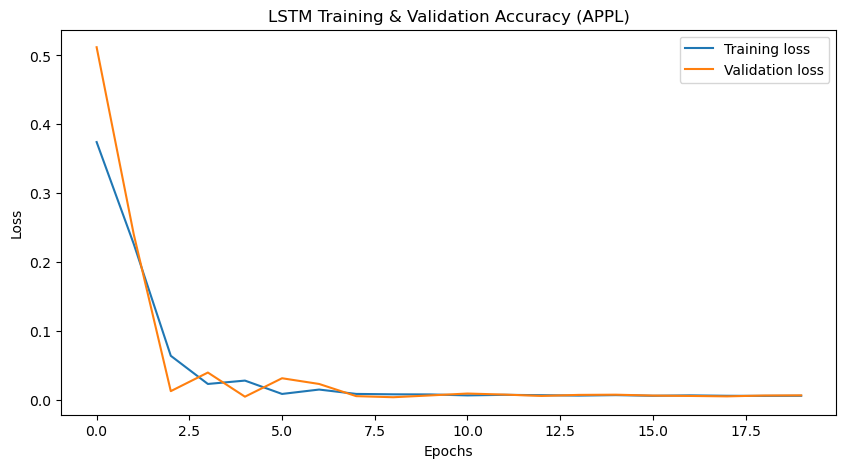

In [9]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label = "Training loss")
plt.plot(history.history['val_loss'], label = "Validation loss")
plt.legend()
plt.title("LSTM Training & Validation Accuracy (APPL)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


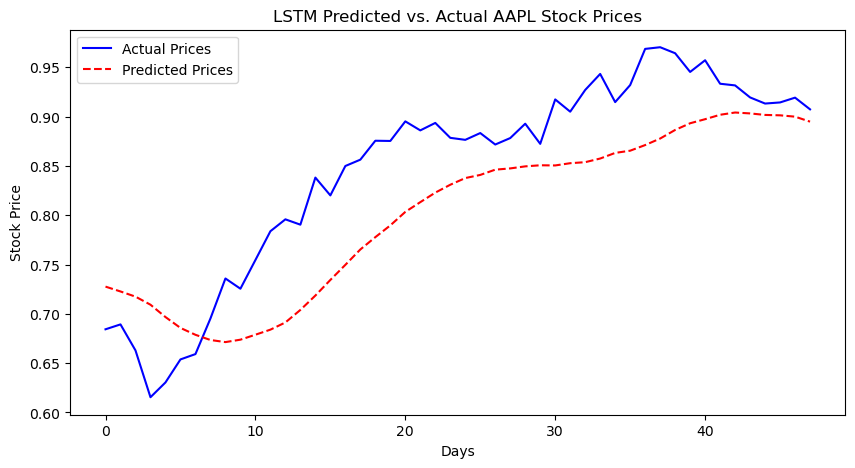

In [10]:
# Get model predictions on the test set
y_pred = lstm_appl.predict(X_test)

# Scale data back to original range

scaler.fit(y_train.reshape(-1, 1))
y_pred_rescaled = scaler.inverse_transform(y_pred) 
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1)) 

# Plot actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(y_test_rescaled, label="Actual Prices", color="blue")
plt.plot(y_pred_rescaled, label="Predicted Prices", color="red", linestyle="dashed")
plt.legend()
plt.title("LSTM Predicted vs. Actual AAPL Stock Prices")
plt.xlabel("Days")
plt.ylabel("Stock Price")
plt.show()

In [11]:
# GRU

warnings.filterwarnings("ignore")

def build_gru_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape = input_shape),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25, activation="relu"),
        Dense(1)
    ])

    model.compile(optimizer="adam", loss="mean_squared_error")
    return model

# Define model

gru_appl = build_gru_model((X_train.shape[1],X_train.shape[2]))

# Print summary

gru_appl.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 1, 50)          │        12,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,701 (131.64 KB)

 Trainable params: 33,701 (131.64 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# train the model

history = gru_appl.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.4040 - val_loss: 0.6019
Epoch 2/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3154 - val_loss: 0.4668
Epoch 3/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2363 - val_loss: 0.2973
Epoch 4/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1246 - val_loss: 0.1175
Epoch 5/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0366 - val_loss: 0.0071
Epoch 6/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0141 - val_loss: 0.0139
Epoch 7/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0233 - val_loss: 0.0038
Epoch 8/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0118 - val_loss: 0.0166
Epoch 9/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0112 - val_loss: 0.0238
Epoch 10/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0124 - val_loss: 0.0142
Epoch 11/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0090 - val_loss: 0.0065
Epoch 12/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0092 - val_loss: 0.0056
Ep

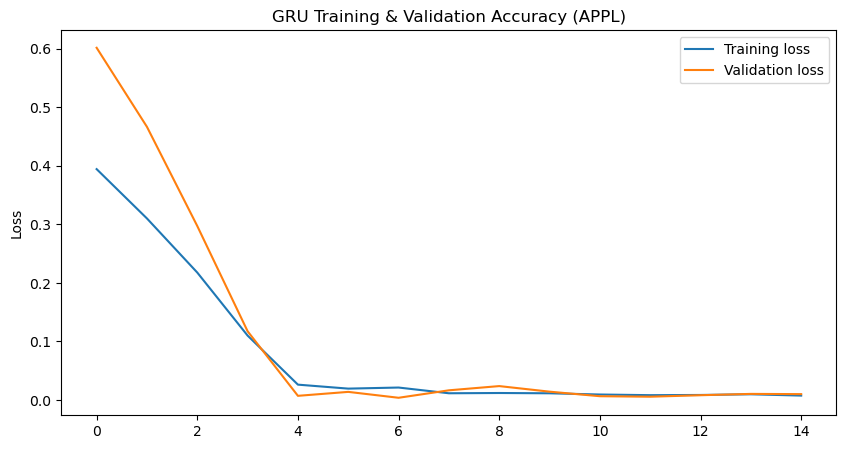

In [13]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label = "Training loss")
plt.plot(history.history['val_loss'], label = "Validation loss")
plt.legend()
plt.title("GRU Training & Validation Accuracy (APPL)")
plt.ylabel("Loss")
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


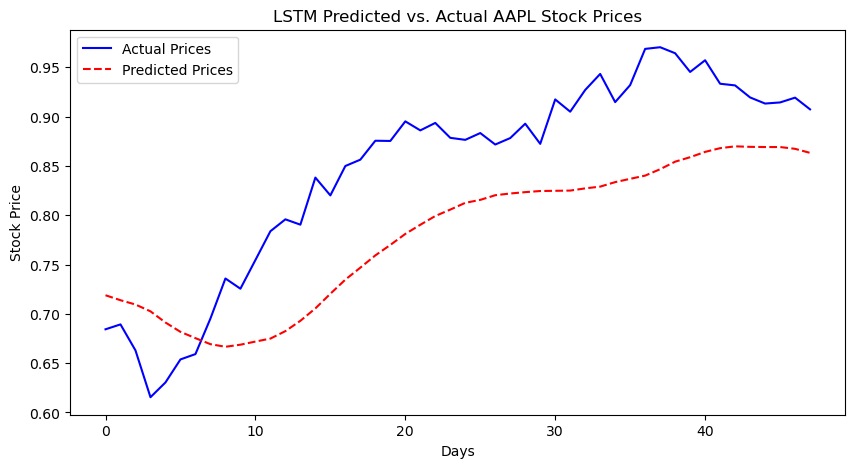

In [14]:
# Get model predictions on the test set
y_pred = gru_appl.predict(X_test)

# Scale data back to original range

scaler.fit(y_train.reshape(-1, 1))
y_pred_rescaled = scaler.inverse_transform(y_pred) 
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1)) 

# Plot actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(y_test_rescaled, label="Actual Prices", color="blue")
plt.plot(y_pred_rescaled, label="Predicted Prices", color="red", linestyle="dashed")
plt.legend()
plt.title("LSTM Predicted vs. Actual AAPL Stock Prices")
plt.xlabel("Days")
plt.ylabel("Stock Price")
plt.show()